In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
import warnings
from matplotlib import pyplot as plt
%matplotlib inline
plt.ion()  # Turn on interactive mode

from IPython import display
import threading


In [2]:
###################################################### Defining our Constants ######################################################
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()
GPIO.setmode(GPIO.BCM)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c

# The number of encoder steps per revolution. This was calculated according to the math that Lacie had in Notion.
MAX_ENC_STEPS = 900

# Motor Pins
ML_IN1 = 17 # IN1 
ML_IN2 = 27 # IN2
ML_ENA = 11 # Used for PWM

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9 # Used for PWM

# Physical dimensions
WHEEL_RADIUS = 0.027 # meters
WHEEL_SEP = 0.229 # meters

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""


/tmp/ipykernel_2511/3200453270.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


'\n    <------- l ------->\n    |                 |\n ___|___           ___|___\n|       |         |       |\n|   O   |         |   O   |\n|_______|         |_______|\n    ^                 ^\n    |                 |\n  Left wheel       Right wheel\n  center            center\n'

In [3]:

###################################################### Class Definitions ######################################################


class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.05, 
            real_time=False,
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position, meters
        self.y = 0.0  # y-position, meters
        self.th = 0.0  # orientation, angle in radians
        
        self.wl = 0.0  # rotational velocity left wheel, rad/s
        self.wr = 0.0  # rotational velocity right wheel, rad/s
        
        self.dt = dt # time delta in seconds. The control loop runs every dt. Faster means the control loop runs more often. We can increase this to reduce CPU load on our robot.
        self.r = wheel_radius # wheel radius in meters.
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        
        self.real_time = real_time # if True, the wheel velocity measurements consider the actual time elapsed between measurements. If False, it uses the predefined dt value.
        self.last_update = None # last time the control loop ran

        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. Note, this is NOT in radians. It counts from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS (wraps around to -ve value)
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency. This works well for our motor. Remember that motor speed is controlled by varying the duty cycle of our PWM frequency, and not the frequency itself. 
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
    '''
    This method calculates the change in encoder steps between the current and previous time step.
    The logic might seem complicated but this is to deal with the wraparound in value (from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS) that the encoder values have.
    e.g. for the first rotation, the encoder goes from 0 to 3600, then for every rotation thereafter, it goes from -3600 to 3600, then wraps around again.
    '''
    def get_encoder_delta(self, curr_value, prev_value):
        raw_delta = curr_value - prev_value
        delta = raw_delta
        wraparound_thresh = np.ceil((2*self.max_enc_steps + 1) / 2)
        
        if raw_delta > wraparound_thresh:
            delta = raw_delta - (2*self.max_enc_steps+1)
        elif raw_delta < -wraparound_thresh:
            delta = raw_delta + (2*self.max_enc_steps+1)
        
        return delta
            
    def get_dt(self):
        #TODO: Implement smoothing for dt - potentially moving average
        if not self.real_time:
            return self.dt
        
        now = time.time()
        # print(f"Last update: {self.last_update}")
        if self.last_update is None:
            self.last_update = now
            return self.dt
        
        dt = now - self.last_update
        self.last_update = now # this needs to be in between the above and below lines. Don't move it 
        return dt
    
    # Wheel velocities in radians/sec
    '''
    This method reads the encoder values and calculates the wheel velocities in rad/s.
    It uses the get_encoder_delta method to calculate the change in encoder steps between the current and previous time step.
    It then converts this change in steps to radians, and then to radians per second.
    '''
    def read_wheel_velocities(self, dt):
        
        ml_enc_now, mr_enc_now = self.ML_ENC.steps, self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = self.get_encoder_delta(ml_enc_now, self.ml_enc_steps)
        mr_enc_delta = self.get_encoder_delta(mr_enc_now, self.mr_enc_steps)

        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi 
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / dt # rad/s
        self.wr = mr_delta_rad / dt # rad/s

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  
    '''
    This method sets the motor speed based on the duty cycle provided. 
    It also sets the direction of the motor based on the sign of the duty cycle.
    The duty cycle is the percentage of time the motor is on, and it MUST be a value between -100 and 100.
    '''
    def set_motor_speed(self, left_duty_cycle, right_duty_cycle):      
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)
            
        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle))
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle))


    '''
    This method calculates the linear and angular velocity of the robot based on the wheel velocities.
    It uses the formulae for differential drive robots to calculate the linear and angular velocity.
    This is pretty much identical to Michael's code in the ECE4191 repo.
    '''
    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0 # linear velocity, m/s, +ve is forward
        w = -(wl * self.r - wr * self.r) / self.l # angular velocity, rad/s, +ve is CCW. Note that the negative sign
        # is due to the way the motors are oriented, and so we need it to 'correct' our w calculation
        # so that +ve w is CCW, adhering to convention.
        return v, w
    
    
    """
    This method updates the robot's pose (x, y, theta) based on the wheel velocities.
    It uses the base_velocity method to calculate the linear and angular velocity of the robot.
    It then uses these velocities to update the robot's pose (x, y, theta) based on the kinematic equations.
    """
    def pose_update(self, duty_cycle_ml, duty_cycle_mr):
        # TODO: remove the call to get_dt here, relocate it to the read_wheel_velocities method, and remove the need for it in the pose_update method (below) by having read_wheel_velocities return dt, or the distance travelled (dt*v) directly.
        dt = self.get_dt()
        
        self.set_motor_speed(duty_cycle_ml, duty_cycle_mr)

        wl, wr = self.read_wheel_velocities(dt) # get wheel velocities in rad/s
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + dt * v * np.cos(self.th)
        self.y = self.y + dt * v * np.sin(self.th)
        self.th = self.th + w * dt
        
        return self.x, self.y, self.th

    
class RobotController:
    def __init__(self, Kp, Ki, dt=0.05, wheel_radius = 0.028, wheel_sep = 0.222, integral_windup=True, real_time=False):
        self.Kp = Kp            # Proportional gain
        self.Ki = Ki            # Integral gain
        self.dt = dt            # Time step
        
        self.r = wheel_radius
        self.l = wheel_sep
        
        self.min_output = -100  # Minimum duty cycle (-100%)
        self.max_output = 100  # Maximum duty cycle (100%)
        
        self.ml_integral = 0       # Integral term, motor left
        self.mr_integral = 0       # Integral term, motor right
        self.ml_last_update, self.mr_last_update = None, None  # Last update time

        self.anti_integral_windup = integral_windup  # Anti-windup flag
        self.real_time = real_time

    """
    Gets the time of the last measurement/update for the motor ml or mr
    """
    def get_dt(self, motor=None):
        #TODO: Implement smoothing for dt - potentially moving average
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")

        if not self.real_time:
            return self.dt
        
        last_update = f"{motor}_last_update"
        now = time.time()
#         print(f"Last update: {getattr(self, last_update)}")
        if getattr(self, last_update) is None:
            setattr(self, last_update, now)
            return self.dt
        
        dt = now - getattr(self, last_update)
        setattr(self, last_update, now)
        return dt


    def compute(self, w_target, w_actual, motor=None):
        # motor should be either "ml" or "mr" for left or right motor
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")
        integral_attr = f"{motor}_integral"
        last_update = f"{motor}_last_update"
        
        dt = self.get_dt(motor)
        
        error = w_target - w_actual # Calculate the error
        P_out = self.Kp * error # Proportional term
        I_out = self.Ki * getattr(self,integral_attr) # Integral term
        raw_output = P_out + I_out

        if self.anti_integral_windup:
            # Anti-windup - only integrate if output is not saturated
            if self.min_output < raw_output < self.max_output:
                setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                # equiv. to self.ml_integral += error * self.dt or self.mr_integral += error * self.dt
        else:
            setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                        
            
        return np.clip(raw_output, self.min_output, self.max_output) # Clamp the output to the min/max duty cycle limits
        
    
    def diff_drive_control(self, v_desired, w_desired, wl_actual, wr_actual):
        # v_desired: m/s
        # w_desired (rotation), wl_actual, w_actual (rotation): rad/s
        
        # Calculate desired wheel angular velocities
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
#         print(f"wl_des (rad/s): {wl_desired:.2f}, wr_des: {wr_desired:.2f}\nwl_des (rps): {wl_desired/(2*np.pi):.2f}, wr_des: {wr_desired/(2*np.pi):.2f}")

        # Compute duty cycles for left and right wheels
        duty_cycle_l = self.compute(wl_desired, wl_actual, 'ml')
        duty_cycle_r = self.compute(wr_desired, wr_actual, 'mr')
        return duty_cycle_l, duty_cycle_r, wl_desired, wr_desired

    

In [ ]:
"""
Just initalising the robot. The argument is dt, or how often the robot control loop should run. See the robot controller class or the below control loop for more explanation.
"""
GPIO.setwarnings(False)
robot = DiffDriveRobot(0.05, real_time=False)

In [ ]:


# Main control loop

# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.2
w_desired = 0.0

# Controller Parameters
Kp = 8
Ki = 9.2

# Initialising
controller = RobotController(Kp, Ki, real_time=False)
robot.x = 0
robot.y = 0
robot.th = 0
robot.wl = 0
robot.wr = 0

poses = []
velocities = []
desired_velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []


start_time, last_time = time.time(), time.time()

try:
    while True: 
        current_time = time.time()
        actual_dt = current_time - last_time
        
        duty_cycle_l, duty_cycle_r, wl_desired, wr_desired = controller.diff_drive_control(v_desired, w_desired, robot.wl, robot.wr)
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        display.clear_output(wait=True)
#         print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}")
        print(f"wl_desired: {wl_desired:.2f}, wr_desired: {wr_desired:.2f}")
        print(f"wl_actual: {robot.wl:.2f}, wr_actual: {robot.wr:.2f}")
        print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
#         print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")

        
        # Log data
        # Here, I record and log everything so we can graph it.
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        desired_velocities.append([wl_desired, wr_desired])
#         error_sums.append([controller.e_sum_l, controller.e_sum_r])
#         errors.append([controller.e_l_prev, controller.e_r_prev])
        actual_dts.append(actual_dt)
        
        
        last_time = current_time
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time


    # Plot robot data
#     display.clear_output(wait=True)
    fig = plt.figure(figsize=(15,9))
    
    plt.subplot(2, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
    plt.axis('equal')
    plt.grid()

    plt.subplot(2, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(2, 2, 3)
    velocities = np.array(velocities)
    desired_velocities = np.array(desired_velocities)
    plt.plot(velocities[:, 0], label='Left Wheel')
    plt.plot(velocities[:, 1], label='Right Wheel')
    plt.plot(desired_velocities[:, 0], label='Desired Left Wheel')
    plt.plot(desired_velocities[:, 1], label='Desired Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Wheel Velocity (rad/s)')
    plt.title('Wheel Velocity vs. Time')
    plt.legend() 
    plt.grid()
    
#     plt.subplot(3, 2, 4)
#     error_sums = np.array(error_sums)
#     plt.plot(error_sums[:, 0], label='Left Wheel')
#     plt.plot(error_sums[:, 1], label='Right Wheel')
#     plt.xlabel('Time Step')
#     plt.ylabel('Accum. Error')
#     plt.title('Accum. Wheel Error Over Time')
#     plt.legend() 
#     plt.grid()
        
#     plt.subplot(3, 2, 5)
#     errors = np.array(errors)
#     plt.plot(errors[:, 0], label='Left Wheel')
#     plt.plot(errors[:, 1], label='Right Wheel')
#     plt.xlabel('Time Step')
#     plt.ylabel('Error per Iteration')
#     plt.title('Wheel Error vs. Iteration')
#     plt.legend() 
#     plt.grid()
    
    plt.subplot(2, 2, 4)
    plt.plot(range(len(actual_dts)), actual_dts)
    plt.xlabel('Loop Iteration')
    plt.ylabel('Loop Interval, dt / s')
    plt.title('Control Loop Intervals for Each Iteration')
    plt.grid()
        
    fig.tight_layout()

    display.display(plt.gcf())

#     GPIO.cleanup()

    """
    Hopefully the graphs are self explanatory. If not, please ask me. I'm happy to explain anything.
    """


In [4]:

class Orchestrator:
    def __init__(self):
        self.running = True
        self.last_update = None
        self.dt = 0.1
        
        self.robot = DiffDriveRobot(0.05, real_time=True)

        self.controller = None
        
        self.control_thread = None
        
        self.poses = []
        self.velocities = []
        self.duty_cycle_commands = []
        self.error_sums = []
        self.errors = []
        self.actual_dts = []

        self.duration = 0

                
    def get_dt(self): 
        now = time.time()
        # print(f"Last update: {self.last_update}")
        if self.last_update is None:
            self.last_update = now
            return self.dt
        
        dt = now - self.last_update
        self.last_update = now # this needs to be in between the above and below lines. Don't move it 
        return dt
    
    
    # Edit this to change what the robot does
    def control_loop(self):

        v_target = 0.5
        w_target = 0.0
        
        while self.running:
            duty_cycle_l, duty_cycle_r = self.controller.diff_drive_control(v_target, w_target, self.robot.wl, self.robot.wr)
            x, y, th = self.robot.pose_update(duty_cycle_l, duty_cycle_r)

            print(f"v_des: {v_target:.2f}, w_des: {w_target:.2f}, wl_actual: {robot.wl:.2f}, wr_actual: {robot.wr:.2f}")
            print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
            
            # Store data for plotting        
            self.poses.append([x,y,th])
            self.duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
            self.velocities.append([self.robot.wl,self.robot.wr])
            self.error_sums.append([self.controller.e_sum_l, self.controller.e_sum_r])
            self.errors.append([self.controller.e_l_prev, self.controller.e_r_prev])
            self.actual_dts.append(self.get_dt())
            
            time.sleep(self.dt)
    
    def start(self):
        if self.robot is None:
            print("Initialising robot.")
#             self.robot = DiffDriveRobot(0.05, real_time=True)

        if self.controller is None:
            print("Initialising controller.")
            self.controller = RobotController(8, 9.2, real_time=True)
            
        self.control_thread = threading.Thread(target=self.control_loop)
        self.control_thread.start()
    
    def stop(self):
        self.running = False
        self.control_thread.join()
        self.robot.set_motor_speed(0, 0)
        self.duration = time.time() - self.control_thread.start_time
        print(f"Ended run. Robot ran for: {self.duration:.2f} s")
        


def update_plot(orchestrator, fig, axes):
    for ax in axes:
        ax.clear()
    
    poses = np.array(orchestrator.poses)
    duty_cycle_commands = np.array(orchestrator.duty_cycle_commands)
    
    # Plot 1: Robot path and orientation
    if len(poses) > 0:
        axes[0].plot(np.array(poses)[:,0],np.array(poses)[:,1])
        x, y = poses[-1]
        th = thetas[-1]
        axes[0].plot(x, y, 'k', marker='+')
        axes[0].quiver(x, y, 0.1*np.cos(th), 0.1*np.sin(th))
    axes[0].set_xlabel('x-position (m)')
    axes[0].set_ylabel('y-position (m)')
    axes[0].set_title(f"Kp: {orchestrator.controller.Kp}, Ki: {orchestrator.controller.Ki}")
    axes[0].axis('equal')
    axes[0].grid()

    # Plot 2: Duty cycle commands
    if len(duty_cycle_commands) > 0:
        axes[1].plot(controller.time, duty_cycle_commands[:, 0], label='Left Wheel')
        axes[1].plot(controller.time, duty_cycle_commands[:, 1], label='Right Wheel')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Duty Cycle')
    axes[1].set_title('Duty Cycle Commands Over Time')
    axes[1].legend()
    axes[1].grid()

    fig.tight_layout()
    display.clear_output(wait=True)
    display.display(fig)

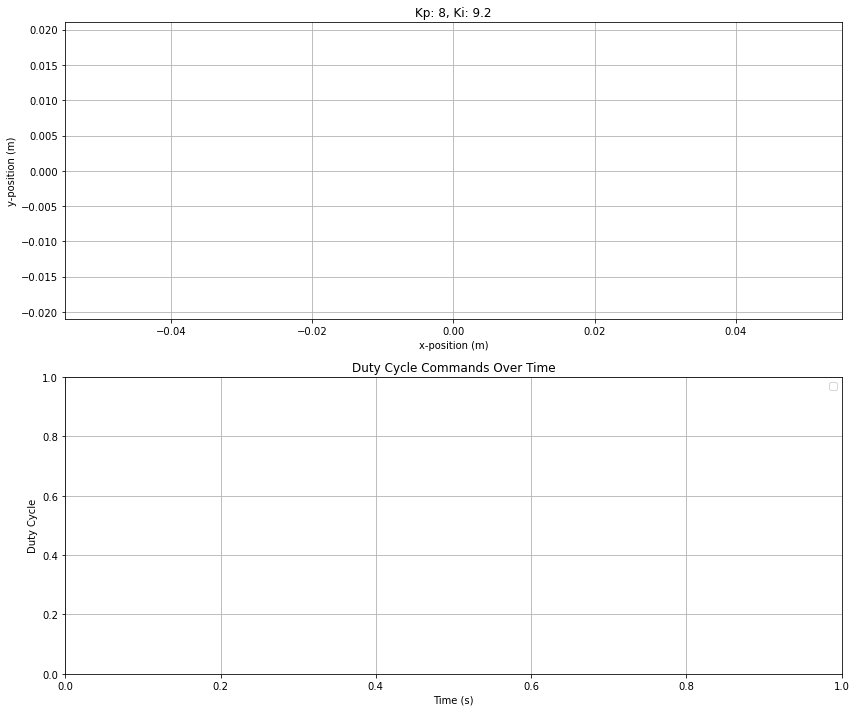

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
#Create the controller and start the control loop
orchestrator = Orchestrator()
orchestrator.start()

# Set up the plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Main loop for updating the plot
try:
    while True:
        update_plot(orchestrator, fig, axes)
        time.sleep(0.1)  # Update plot every 0.1 seconds
except KeyboardInterrupt:
    print("Stopping the simulation...")
finally:
    orchestrator.stop()
    plt.close(fig)

print("Simulation ended.")

In [ ]:
###################

# Choose option 1 to have the motors turn and print out encoder steps.
# What you're looking for is:
# - The correct motor is spinning, i.e. only the left motor spins if you do robot.set_motor_speed(0, 1)
#     - If the wrong motor spins, check pin assignments.
# - The motor is spinning in the correct direction for the given velocity. e.g. Forwards for 1, backwards for -1.
#.    - To reverse direction, swap the IN1 / IN2 assignments or IN3 / IN4 assignments. 
# - The encoder values are correct for the given velocity. e.g. they should be counting upwards if velocity is positive.
#     - If encoder values are always 0, check that the motor cables are plugged in correctly.
#.    - If they're counting the wrong direction, you need to swap the ENC_A and ENC_B pin assignments for the appropriate encoder


# Choose option 2 to test the pose_update method


robot.ML_ENC.steps = 0
robot.MR_ENC.steps = 0

OPTION = 0






################

if OPTION==1:
    # First argument is the left motor, second argument is the right motor.
    robot.set_motor_speed(0.3, 0.3)


poses = []
velocities = []
duty_cycle_commands = []

if OPTION != 0:
    try:
        while True:
            if OPTION == 1:
                left_steps = robot.ML_ENC.steps
                right_steps = robot.MR_ENC.steps
                print(f"l: {left_steps}, r: {right_steps}")
                if abs(left_steps) >= MAX_ENC_STEPS-2 or abs(right_steps) >= MAX_ENC_STEPS-2:
                    robot.set_motor_speed(0, 0)
                    break
                wl, wr = robot.read_wheel_velocities()
                print(f"wl: {wl}, wr: {wr}")

            elif OPTION == 2:
                x, y, th = robot.pose_update(1, 1)
                poses.append([x,y,th])
                velocities.append([robot.wl,robot.wr])
                print(f"x:{x:.2f}, y:{y:.2f}, th: {th:.2f}\n")

            time.sleep(robot.dt)


    except KeyboardInterrupt:
        print("Stopping robot")
        robot.set_motor_speed(0, 0)

In [ ]:
# # Real time, updating graphs. 
# # Do not use for now, interferes with velocity control.

# plt.figure(figsize=(15,9))


# # Example: Move forward at 0.5 m/s with no rotation
# Kp = 0.6
# Ki = 0.0

# v_desired = 0.5
# w_desired = 0.0


# # Vars
# poses = []
# velocities = []
# duty_cycle_commands = []
# errors = []
# actual_dts = []
# i = 0
# controller = RobotController(Kp, Ki)
# start_time, last_time = time.time(), time.time()

# try:
#     while True:        
#         # Example motion using controller 

# #         if i < 100: # drive in circular path (turn left) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,1,robot.wl,robot.wr)
# #         elif i < 200: # drive in circular path (turn right) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,-1,robot.wl,robot.wr)
# #         else: # stop
# #             duty_cycle_l,duty_cycle_r = (0,0)

#         # Simulate robot motion - send duty cycle command to robot
# #         x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)

#         current_time = time.time()
#         actual_dt = current_time - last_time

#         duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)
#         x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
      
        
#         # Log data
#         poses.append([x,y,th])
#         duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
#         velocities.append([robot.wl,robot.wr])
#         errors.append([controller.e_sum_l, controller.e_sum_r])
#         actual_dts.append(actual_dt)

#         # Plot robot data
#         plt.clf()
#         plt.cla()
#         plt.subplot(1,3,1)
#         plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
#         plt.plot(x,y,'k',marker='+')
#         plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
# #         plt.xlim(-1,1)
# #         plt.ylim(-1,1)
#         plt.xlabel('x-position (m)')
#         plt.ylabel('y-position (m)')
#         plt.grid()

#         plt.subplot(3,2,2)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Duty cycle')
#         plt.grid()

#         plt.subplot(3,2,4)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Wheel $\omega$')
#         plt.legend(['Left wheel', 'Right wheel'])
#         plt.grid()

#         plt.subplot(3,2,6)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(actual_dts))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Loop Iteration Duration')
#         plt.grid()

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        
#         i += 1
#         last_time = current_time
#         time.sleep(robot.dt)

        
# except KeyboardInterrupt:
#     print("Stopping robot")
#     robot.set_motor_speed(0, 0)

In [ ]:
    robot.set_motor_speed(0, 0)